# IMPORT ALL REQUIRED LIBRARIES

In [ ]:

import os
import shutil
import glob
import json
import pickle
import time
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import skimage.io as io
from skimage.transform import resize
from sklearn.preprocessing import MinMaxScaler, Normalizer, StandardScaler, RobustScaler, LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, StratifiedKFold, cross_val_score, cross_validate
from sklearn.utils import shuffle
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    accuracy_score,
    f1_score,
    recall_score,
    precision_score,
    auc,
    roc_curve,
    roc_auc_score,
    cohen_kappa_score,
    precision_recall_fscore_support,
    precision_recall_curve,
    ConfusionMatrixDisplay,
    RocCurveDisplay,
    PrecisionRecallDisplay
)
from sklearn.utils import compute_class_weight
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
import tensorflow as tf
from tensorflow.keras import backend as K

import warnings
warnings.filterwarnings("ignore")


In [ ]:
!pip uninstall -y tensorflow-addons
!pip install tfa-nightly

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 620.3/620.3 kB 8.0 MB/s eta 0:00:00
  Attempting uninstall: typeguard
    Found existing installation: typeguard 4.4.2
    Uninstalling typeguard-4.4.2:
      Successfully uninstalled typeguard-4.4.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
inflect 7.5.0 requires typeguard>=4.0.1, but you have typeguard 2.13.3 which is incompatible.


In [ ]:
import tensorflow_addons as tfa

In [ ]:
SEED = 42

import random
import numpy as np
import tensorflow as tf

random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

pd.set_option('display.max_colwidth' , 200)

# EXPLORATORY DATA ANALYSIS

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
BASE_DIR = "/content/drive/MyDrive/RESEARCH_DATA/ALZHAIMER/Data-Alzheimer-with-FCIE"
VAL_DIR, TEST_DIR, TRAIN_DIR = [os.path.join(BASE_DIR, sub)
                                for sub in os.listdir(BASE_DIR)]


TRAIN_DIR = os.path.join(BASE_DIR, "train")
VAL_DIR   = os.path.join(BASE_DIR, "val")
TEST_DIR  = os.path.join(BASE_DIR, "test")

assert os.path.isdir(TRAIN_DIR), f"Folder {TRAIN_DIR} tidak ditemukan"
assert os.path.isdir(VAL_DIR),   f"Folder {VAL_DIR} tidak ditemukan"
assert os.path.isdir(TEST_DIR),  f"Folder {TEST_DIR} tidak ditemukan"


In [ ]:
classes = os.listdir(TRAIN_DIR)
class2label = {}

for i in range(len(classes)):
    class2label[classes[i]] = i

label2class = {v:k for k, v in class2label.items()}

print(class2label)
print("--"*45)
print(label2class)

{'MildDemented': 0, 'NonDemented': 1, 'VeryMildDemented': 2, 'ModerateDemented': 3}
------------------------------------------------------------------------------------------
{0: 'MildDemented', 1: 'NonDemented', 2: 'VeryMildDemented', 3: 'ModerateDemented'}


In [ ]:
train_distribution = {}
print("TRAIN-SET DISTRIBUTION\n")
for cat in classes:
    path = os.path.join(TRAIN_DIR, cat, "*")
    data = glob.glob(path)
    print(f"Number of {cat} Images: {len(data)}")
    train_distribution[cat] = len(data)
    print('--'*20)

test_distribution = {}
print("\nVAL-SET DISTRIBUTION\n")
for cat in classes:
    path = os.path.join(VAL_DIR, cat, "*")
    data = glob.glob(path)
    print(f"Number of {cat} Images: {len(data)}")
    test_distribution[cat] = len(data)
    print('--'*20)

test_distribution = {}
print("\nTEST-SET DISTRIBUTION\n")
for cat in classes:
    path = os.path.join(TEST_DIR, cat, "*")
    data = glob.glob(path)
    print(f"Number of {cat} Images: {len(data)}")
    test_distribution[cat] = len(data)
    print('--'*20)

TRAIN-SET DISTRIBUTION

Number of MildDemented Images: 686
----------------------------------------
Number of NonDemented Images: 2448
----------------------------------------
Number of VeryMildDemented Images: 1714
----------------------------------------
Number of ModerateDemented Images: 49
----------------------------------------

VAL-SET DISTRIBUTION

Number of MildDemented Images: 121
----------------------------------------
Number of NonDemented Images: 432
----------------------------------------
Number of VeryMildDemented Images: 302
----------------------------------------
Number of ModerateDemented Images: 9
----------------------------------------

TEST-SET DISTRIBUTION

Number of MildDemented Images: 89
----------------------------------------
Number of NonDemented Images: 320
----------------------------------------
Number of VeryMildDemented Images: 224
----------------------------------------
Number of ModerateDemented Images: 6
----------------------------------------


In [ ]:
categories = []
image_name = []
image_id = []
image_format = []
labels = []
img_path = []
img_height = []
img_width = []

for cat in classes:
    path = os.path.join(TRAIN_DIR, cat, "*")
    data = glob.glob(path)
    for i in range(len(data)):
        h, w, c = cv2.imread(data[i]).shape
        cls , img = data[i].split('/')[-2:]
        img_id , img_format = img.split('.')
        img_height.append(h)
        img_width.append(w)
        categories.append(cls)
        image_name.append(img)
        image_id.append(img_id)
        image_format.append(img_format)
        labels.append(class2label[cls])
        img_path.append(data[i])

In [ ]:
assert len(categories) == len(image_name) == len(image_id) == len(image_id) == len(image_format) == len(labels) == len(img_path) == len(img_height) == len(img_width)

In [ ]:
data = pd.DataFrame(list(zip(image_id, image_name, image_format, categories, labels, img_path, img_height, img_width)))
data.columns = ['image_id' , 'image_name' , 'format' , 'Class' , 'label' , 'image_path' , 'height' , 'width']
data.sample(10 , random_state = SEED)

,image_id,image_name,format,Class,label,image_path,height,width
144,26 (19),26 (19).jpg,jpg,MildDemented,0,/content/drive/MyDrive/RESEARCH_DATA/ALZHAIMER/Data-Alzheimer-with-FCIE/train/MildDemented/26 (19).jpg,208,176
79,mildDem107,mildDem107.jpg,jpg,MildDemented,0,/content/drive/MyDrive/RESEARCH_DATA/ALZHAIMER/Data-Alzheimer-with-FCIE/train/MildDemented/mildDem107.jpg,208,176
4630,verymildDem1108,verymildDem1108.jpg,jpg,VeryMildDemented,2,/content/drive/MyDrive/RESEARCH_DATA/ALZHAIMER/Data-Alzheimer-with-FCIE/train/VeryMildDemented/verymildDem1108.jpg,208,176
1860,nonDem1298,nonDem1298.jpg,jpg,NonDemented,1,/content/drive/MyDrive/RESEARCH_DATA/ALZHAIMER/Data-Alzheimer-with-FCIE/train/NonDemented/nonDem1298.jpg,208,176
4880,moderateDem20,moderateDem20.jpg,jpg,ModerateDemented,3,/content/drive/MyDrive/RESEARCH_DATA/ALZHAIMER/Data-Alzheimer-with-FCIE/train/ModerateDemented/moderateDem20.jpg,208,176
1831,nonDem1094,nonDem1094.jpg,jpg,NonDemented,1,/content/drive/MyDrive/RESEARCH_DATA/ALZHAIMER/Data-Alzheimer-with-FCIE/train/NonDemented/nonDem1094.jpg,208,176
756,nonDem223,nonDem223.jpg,jpg,NonDemented,1,/content/drive/MyDrive/RESEARCH_DATA/ALZHAIMER/Data-Alzheimer-with-FCIE/train/NonDemented/nonDem223.jpg,208,176
4194,28 (6),28 (6).jpg,jpg,VeryMildDemented,2,/content/drive/MyDrive/RESEARCH_DATA/ALZHAIMER/Data-Alzheimer-with-FCIE/train/VeryMildDemented/28 (6).jpg,208,176
287,mildDem38,mildDem38.jpg,jpg,MildDemented,0,/content/drive/MyDrive/RESEARCH_DATA/ALZHAIMER/Data-Alzheimer-with-FCIE/train/MildDemented/mildDem38.jpg,208,176
2615,nonDem2233,nonDem2233.jpg,jpg,NonDemented,1,/content/drive/MyDrive/RESEARCH_DATA/ALZHAIMER/Data-Alzheimer-with-FCIE/train/NonDemented/nonDem2233.jpg,208,176


In [ ]:
data.shape

(4897, 8)

In [ ]:
data['Class'].value_counts()

,count
Class,
NonDemented,2448
VeryMildDemented,1714
MildDemented,686
ModerateDemented,49


In [ ]:
if data.isnull().sum().sum() == 0:
    print('No Null Values found in dataset')
else:
    print(f'{data.isnull().sum().sum()} null values found in dataset')

# checking for any duplicate values
if data.duplicated().sum() == 0:
    print('No Duplicate Values found in dataset')
else:
    print(f'{data.duplicated().sum()} Duplicate values found in dataset')

No Null Values found in dataset
No Duplicate Values found in dataset


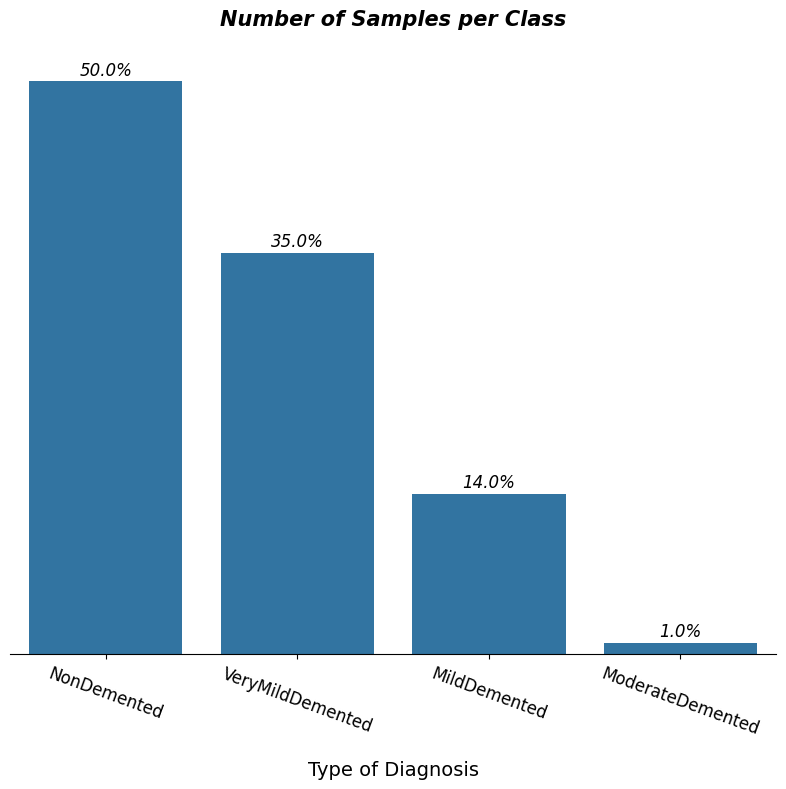

In [ ]:
plt.figure(figsize=(8, 8))

sns.countplot(data = data , x = 'Class' , order = data['Class'].value_counts().index)
sns.despine(top=True, right=True, left=True, bottom=False)

plt.xticks(ticks= [0,1,2,3], labels=data['Class'].value_counts().index.to_list(), fontsize=12, rotation=340)
plt.yticks([])
plt.title('Number of Samples per Class' , fontsize=15 , pad=20 , fontstyle='italic' , fontweight = 800)
plt.xlabel('Type of Diagnosis' , fontsize=14 , fontweight=400, labelpad=16)
plt.ylabel('')
ax = plt.gca()

for p in ax.patches:
    ax.annotate("%.1f%%" % (100*float(p.get_height()/data.shape[0])), (p.get_x() + p.get_width() / 2., abs(p.get_height())), ha='center',
                va='bottom', color='black', xytext=(0,2), rotation='horizontal', textcoords='offset points', fontsize = 12, fontstyle = 'italic')

plt.savefig("samples.png")
plt.tight_layout()

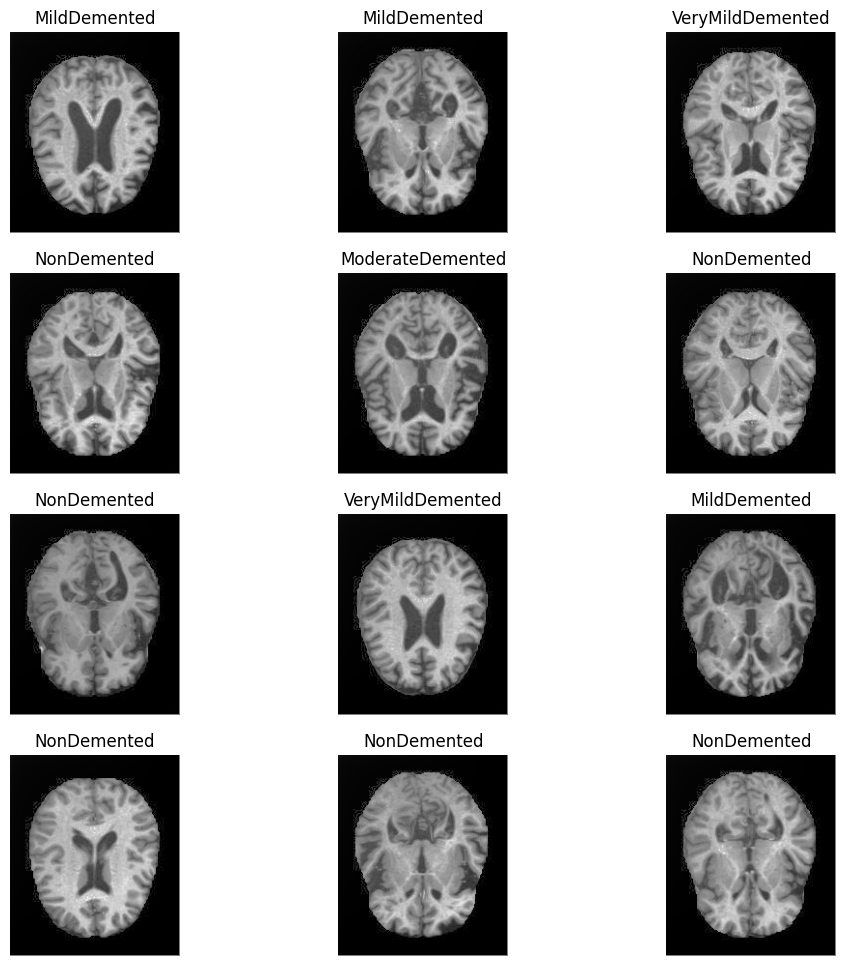

In [ ]:
sample_data = data.sample(12 , random_state = SEED)
sample_imgs = sample_data['image_path'].to_list()

plt.figure(figsize = (12,12))
for i in range(12):
    plt.subplot(4 , 3 , i+1)
    img = cv2.imread(sample_imgs[i])
    plt.title(sample_imgs[i].split('/')[-2], fontsize = 12)
    plt.axis('off')
    plt.imshow(img)


In [ ]:
print('Shape of the image : {}'.format(img.shape))
print('Image Height: {}'.format(img.shape[0]))
print('Image Width: {}'.format(img.shape[1]))
print('Image Dimensions/Channels: {}'.format(img.ndim))
print("=="*20)
print('Image size: {}'.format(img.size))
print('Image Data Type: {}'.format(img.dtype))
print("=="*20)
print('Maximum RGB value in this image {}'.format(img.max()))
print('Minimum RGB value in this image {}'.format(img.min()))

Shape of the image : (208, 176, 3)
Image Height: 208
Image Width: 176
Image Dimensions/Channels: 3
Image size: 109824
Image Data Type: uint8
Maximum RGB value in this image 254
Minimum RGB value in this image 0


In [ ]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array

mean_val = []
std_val = []
max_val = []
min_val = []

for i in range(data.shape[0]):
    img_arr = img_to_array(load_img(data['image_path'][i]))
    mean_val.append(img_arr.mean())
    std_val.append(img_arr.std())
    max_val.append(img_arr.max())
    min_val.append(img_arr.min())

data['mean_pixel'] = mean_val
data['std_dev'] = std_val
data['max_pixel'] = max_val
data['min_pixel'] = min_val

In [ ]:
data['mean_variation'] = data['mean_pixel'].mean() - data['mean_pixel']
data.sample(10)

,image_id,image_name,format,Class,label,image_path,height,width,mean_pixel,std_dev,max_pixel,min_pixel,mean_variation
144,26 (19),26 (19).jpg,jpg,MildDemented,0,/content/drive/MyDrive/RESEARCH_DATA/ALZHAIMER/Data-Alzheimer-with-FCIE/train/MildDemented/26 (19).jpg,208,176,69.001282,73.061958,238.0,0.0,2.044746
79,mildDem107,mildDem107.jpg,jpg,MildDemented,0,/content/drive/MyDrive/RESEARCH_DATA/ALZHAIMER/Data-Alzheimer-with-FCIE/train/MildDemented/mildDem107.jpg,208,176,71.738312,71.365471,253.0,0.0,-0.692284
4630,verymildDem1108,verymildDem1108.jpg,jpg,VeryMildDemented,2,/content/drive/MyDrive/RESEARCH_DATA/ALZHAIMER/Data-Alzheimer-with-FCIE/train/VeryMildDemented/verymildDem1108.jpg,208,176,75.504784,75.536835,255.0,0.0,-4.458755
1860,nonDem1298,nonDem1298.jpg,jpg,NonDemented,1,/content/drive/MyDrive/RESEARCH_DATA/ALZHAIMER/Data-Alzheimer-with-FCIE/train/NonDemented/nonDem1298.jpg,208,176,75.141991,74.604568,253.0,0.0,-4.095963
4880,moderateDem20,moderateDem20.jpg,jpg,ModerateDemented,3,/content/drive/MyDrive/RESEARCH_DATA/ALZHAIMER/Data-Alzheimer-with-FCIE/train/ModerateDemented/moderateDem20.jpg,208,176,68.234291,67.991966,245.0,0.0,2.811737
1831,nonDem1094,nonDem1094.jpg,jpg,NonDemented,1,/content/drive/MyDrive/RESEARCH_DATA/ALZHAIMER/Data-Alzheimer-with-FCIE/train/NonDemented/nonDem1094.jpg,208,176,75.785812,74.490204,253.0,0.0,-4.739784
756,nonDem223,nonDem223.jpg,jpg,NonDemented,1,/content/drive/MyDrive/RESEARCH_DATA/ALZHAIMER/Data-Alzheimer-with-FCIE/train/NonDemented/nonDem223.jpg,208,176,65.109535,63.934048,215.0,0.0,5.936493
4194,28 (6),28 (6).jpg,jpg,VeryMildDemented,2,/content/drive/MyDrive/RESEARCH_DATA/ALZHAIMER/Data-Alzheimer-with-FCIE/train/VeryMildDemented/28 (6).jpg,208,176,69.484047,74.050537,233.0,0.0,1.561981
287,mildDem38,mildDem38.jpg,jpg,MildDemented,0,/content/drive/MyDrive/RESEARCH_DATA/ALZHAIMER/Data-Alzheimer-with-FCIE/train/MildDemented/mildDem38.jpg,208,176,65.353119,65.003426,238.0,0.0,5.692909
2615,nonDem2233,nonDem2233.jpg,jpg,NonDemented,1,/content/drive/MyDrive/RESEARCH_DATA/ALZHAIMER/Data-Alzheimer-with-FCIE/train/NonDemented/nonDem2233.jpg,208,176,77.592628,79.389511,255.0,0.0,-6.546600


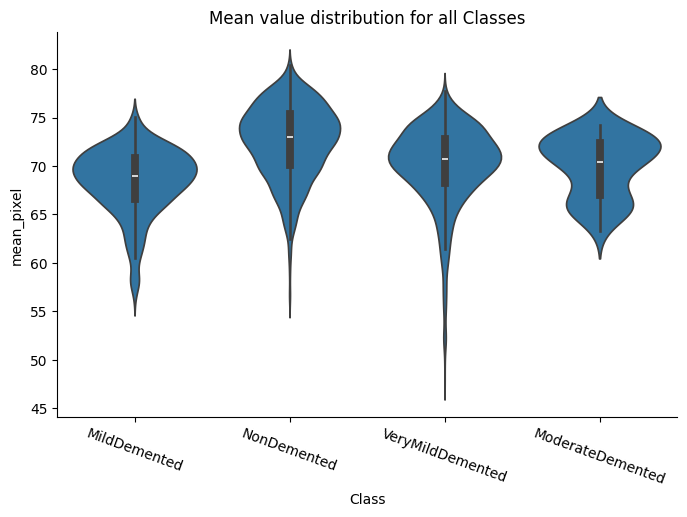

In [ ]:
plt.figure(figsize = (8,5))
sns.violinplot(y = 'mean_pixel' , data = data , x = 'Class')
sns.despine()
plt.xticks(rotation=340)
plt.title('Mean value distribution for all Classes')
plt.show()

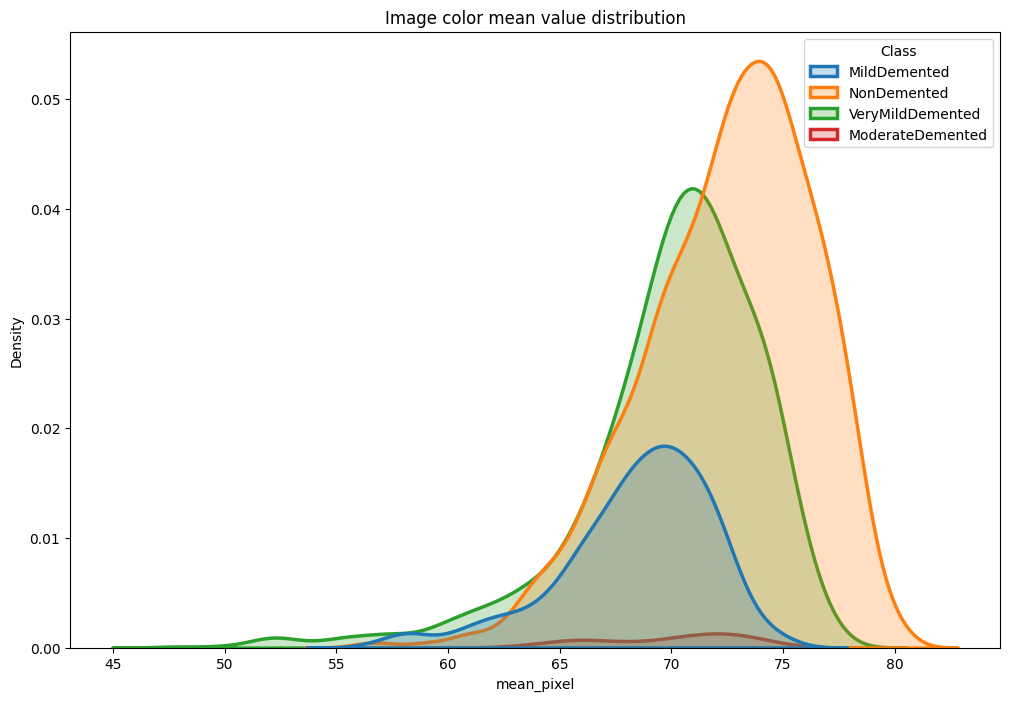

In [ ]:
plt.figure(figsize = (12, 8))
sns.kdeplot(data = data , x = 'mean_pixel' , hue = 'Class' , shade = True , linewidth = 2.5)
plt.title('Image color mean value distribution')
plt.show()

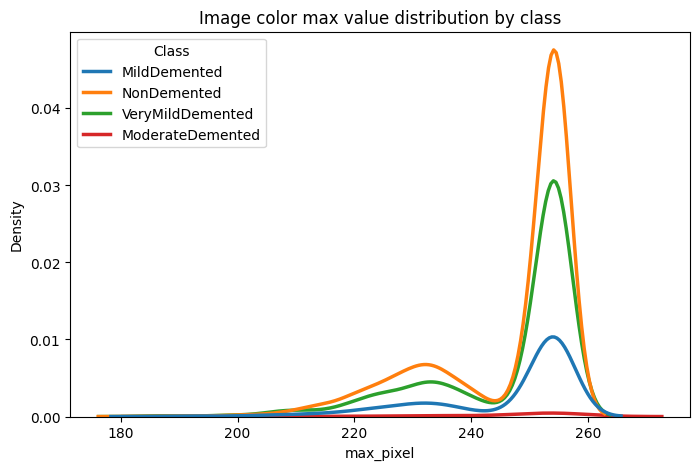

In [ ]:
plt.figure(figsize = (8,5))
sns.kdeplot(data = data , x = 'max_pixel', hue='Class' , linewidth = 2.5)
plt.title('Image color max value distribution by class')
plt.show()

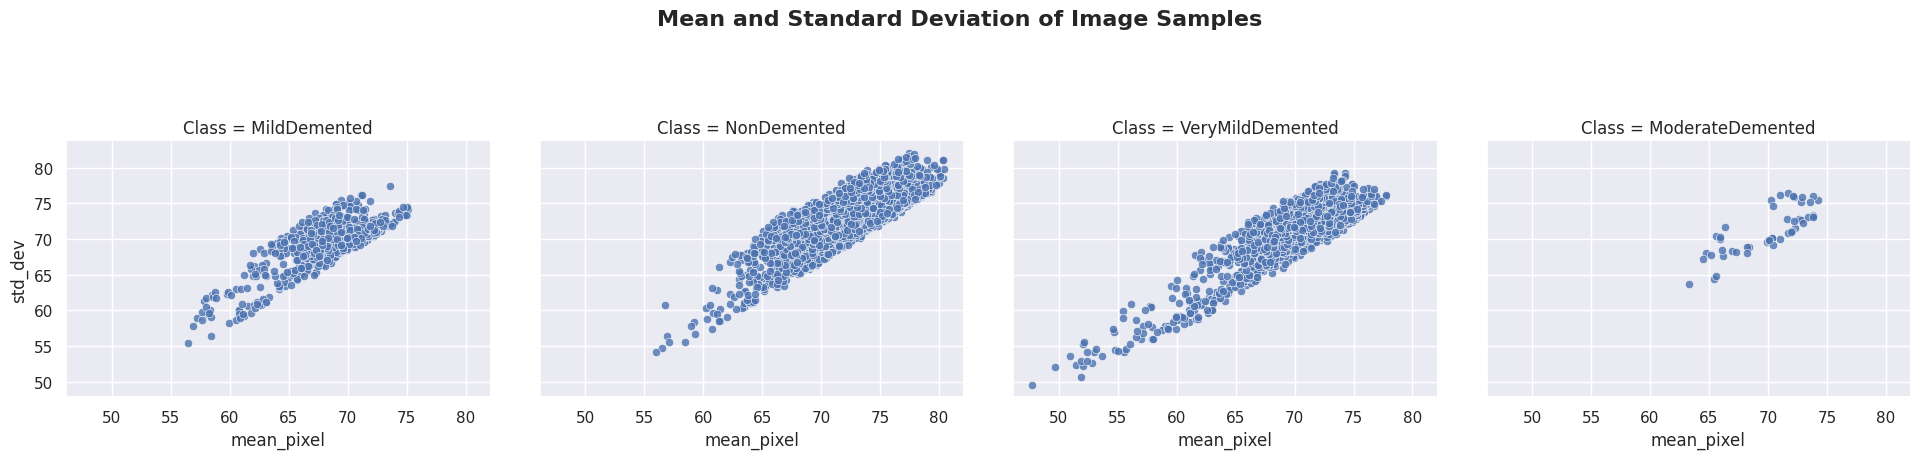

In [ ]:
sns.set(rc={'figure.figsize':(16,8)})
fig = sns.relplot(data=data, x="mean_pixel", y=data['std_dev'],alpha=0.8, kind='scatter',col='Class');
sns.despine(top=True, right=True, left=False, bottom=False)

plt.suptitle('Mean and Standard Deviation of Image Samples', fontsize = 16 , fontweight = 550)
fig.tight_layout(pad=3)

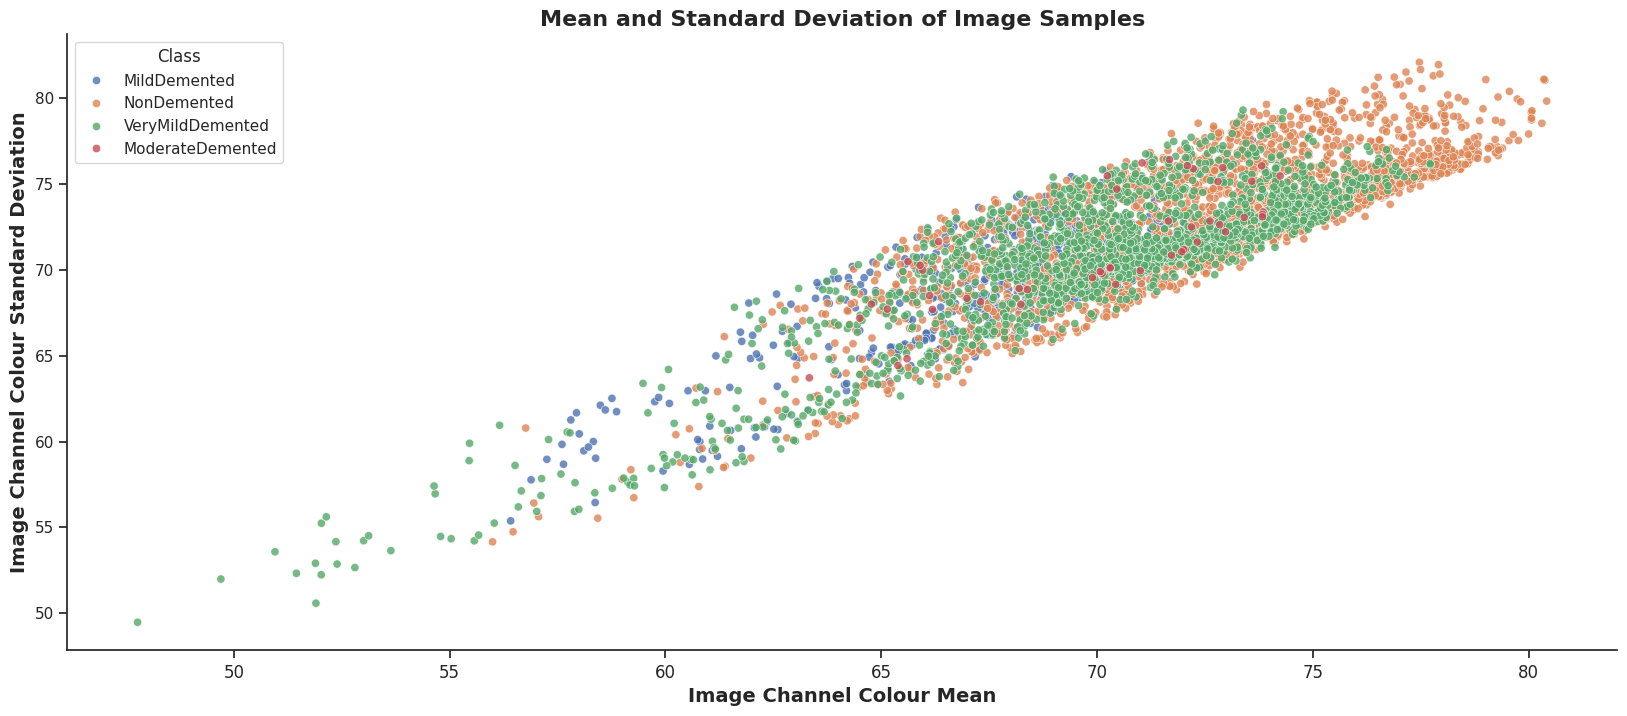

In [ ]:
plt.figure(figsize=(20,8))
sns.set(style="ticks", font_scale = 1)
ax = sns.scatterplot(data=data, x="mean_pixel", y=data['std_dev'], hue = 'Class',alpha=0.8);
sns.despine(top=True, right=True, left=False, bottom=False)
plt.xticks(rotation=0,fontsize = 12)
ax.set_xlabel('Image Channel Colour Mean',fontsize = 14,weight = 'bold')
ax.set_ylabel('Image Channel Colour Standard Deviation',fontsize = 14,weight = 'bold')
plt.title('Mean and Standard Deviation of Image Samples', fontsize = 16,weight = 'bold');

# MODEL TRAINING

In [ ]:
BATCH_SIZE = 64
NUM_EPOCHS = 75
IMG_SIZE = (224,224)
INPUT_SHAPE = (224,224,3)

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   horizontal_flip = True,
                                   brightness_range = [0.6, 1.4],
                                   rotation_range = 15)

val_datagen = ImageDataGenerator(rescale = 1./255)

test_datagen  = ImageDataGenerator(rescale = 1./255)

In [ ]:
train_dataset  = train_datagen.flow_from_directory(directory = TRAIN_DIR,
                                                   target_size = IMG_SIZE,
                                                   color_mode = "rgb",
                                                   class_mode = "categorical",
                                                   batch_size = BATCH_SIZE,
                                                   interpolation = "bicubic" ,
                                                   shuffle = True)

val_dataset = val_datagen.flow_from_directory(directory = VAL_DIR,
                                               target_size = IMG_SIZE,
                                               color_mode = "rgb",
                                               class_mode = "categorical",
                                               batch_size = BATCH_SIZE,
                                               interpolation = "bicubic")

test_dataset = test_datagen.flow_from_directory(directory = TEST_DIR,
                                               target_size = IMG_SIZE,
                                               color_mode = "rgb",
                                               class_mode = "categorical",
                                               batch_size = BATCH_SIZE,
                                               interpolation = "bicubic",
                                               shuffle = False)

Found 4897 images belonging to 4 classes.
Found 864 images belonging to 4 classes.
Found 639 images belonging to 4 classes.


In [ ]:
print('Number of batch iterations on training data' , len(train_dataset))
print('Number of batch iterations on validation data' , len(val_dataset))
print('Number of batch iterations on test data' , len(test_dataset))

Number of batch iterations on training data 77
Number of batch iterations on validation data 14
Number of batch iterations on test data 10


In [ ]:
label2class = train_dataset.class_indices
class2label = {v:k for (k,v) in train_dataset.class_indices.items()}

print(label2class)
print(class2label)

{'MildDemented': 0, 'ModerateDemented': 1, 'NonDemented': 2, 'VeryMildDemented': 3}
{0: 'MildDemented', 1: 'ModerateDemented', 2: 'NonDemented', 3: 'VeryMildDemented'}


In [ ]:
checkpoint_dir = "./temp/"

checkpoint_filepath = os.path.join(checkpoint_dir, "best_model.keras")

In [ ]:
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.metrics import Recall, Precision, AUC
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import os

optimizer = SGD(learning_rate=0.001, momentum=0.9, nesterov=True, decay=1e-6)
metrics = ["accuracy", Recall(), Precision(), AUC()]

early_stop = EarlyStopping(monitor='val_loss', patience=8, mode='min', verbose=1)
checkpoint = ModelCheckpoint(filepath=checkpoint_filepath, monitor="val_loss", verbose=1, save_best_only=True, mode="min")
lr_reduction = ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=5, verbose=1, mode="min")
callbacks_list = [early_stop, lr_reduction, checkpoint]

In [ ]:
def categorical_focal_loss(gamma=2.0, alpha=0.25):
    """
    Implementation of Focal Loss from the paper in multiclass classification
    Formula:
        loss = -alpha*((1-p)^gamma)*log(p)
    Parameters:
        alpha -- the same as wighting factor in balanced cross entropy
        gamma -- focusing parameter for modulating factor (1-p)
    Default value:
        gamma -- 2.0 as mentioned in the paper
        alpha -- 0.25 as mentioned in the paper
    """
    def focal_loss(y_true, y_pred):
        # Define epsilon so that the backpropagation will not result in NaN
        # for 0 divisor case
        epsilon = K.epsilon()
        # Add the epsilon to prediction value
        #y_pred = y_pred + epsilon
        # Clip the prediction value
        y_pred = K.clip(y_pred, epsilon, 1.0-epsilon)
        # Calculate cross entropy
        cross_entropy = -y_true*K.log(y_pred)
        # Calculate weight that consists of  modulating factor and weighting factor
        weight = alpha * y_true * K.pow((1-y_pred), gamma)
        # Calculate focal loss
        loss = weight * cross_entropy
        # Sum the losses in mini_batch
        loss = K.sum(loss, axis=1)
        return loss

    return focal_loss

In [ ]:
from tensorflow.keras.layers import Dropout, Flatten, Dense, Activation
from tensorflow.keras.models import Model
from tensorflow.keras.applications import VGG16 # Import VGG16

base_model = VGG16(input_shape=(224, 224, 3), include_top=False, weights="imagenet")
x = base_model.output
x = Dropout(0.25)(x)
x = Flatten()(x)

x = Dense(4096, kernel_initializer='he_uniform')(x)
x = Activation('relu')(x)
x = Dropout(0.25)(x)
x = Dense(4096, kernel_initializer='he_uniform')(x)
x = Activation('relu')(x)
x = Dropout(0.25)(x)

x = Dense(1000, kernel_initializer='he_uniform')(x)
x = Activation('relu')(x)
x = Dropout(0.25)(x)

output = Dense(4, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=output, name="VGG16_Alzheimer")

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
model.summary()

Model: "VGG16_Alzheimer"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4096)           │   102,764,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4096)           │    16,781,31

 Total params: 138,361,548 (527.81 MB)

 Trainable params: 138,361,548 (527.81 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model.compile(optimizer = optimizer, loss = "categorical_crossentropy", metrics = metrics)

In [ ]:
hist = model.fit(x=train_dataset, epochs=NUM_EPOCHS, callbacks=[callbacks_list], steps_per_epoch=len(train_dataset),
                 validation_data=val_dataset, validation_steps=len(val_dataset))

Epoch 1/75
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4482 - auc_3: 0.7431 - loss: 1.2337 - precision_3: 0.4648 - recall_3: 0.3054
Epoch 1: val_loss improved from inf to 1.04946, saving model to ./temp/best_model.keras
77/77 ━━━━━━━━━━━━━━━━━━━━ 399s 4s/step - accuracy: 0.4483 - auc_3: 0.7433 - loss: 1.2323 - precision_3: 0.4649 - recall_3: 0.3048 - val_accuracy: 0.5000 - val_auc_3: 0.7936 - val_loss: 1.0495 - val_precision_3: 0.0000e+00 - val_recall_3: 0.0000e+00 - learning_rate: 0.0010
Epoch 2/75
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4698 - auc_3: 0.7662 - loss: 1.0771 - precision_3: 0.4765 - recall_3: 0.1618
Epoch 2: val_loss improved from 1.04946 to 1.03598, saving model to ./temp/best_model.keras
77/77 ━━━━━━━━━━━━━━━━━━━━ 89s 1s/step - accuracy: 0.4699 - auc_3: 0.7664 - loss: 1.0768 - precision_3: 0.4769 - recall_3: 0.1626 - val_accuracy: 0.5000 - val_auc_3: 0.8078 - val_loss: 1.0360 - val_precision_3: 0.5000 - val_recall_3: 0.5000 - learning_rate: 0.0010
E

# EVALUATION AND PREDICTIONS

In [ ]:
metricsEval = list(hist.history.keys())
print(metricsEval , '\n')

historyDF = pd.DataFrame(hist.history)
historyDF.head()

['accuracy', 'auc_3', 'loss', 'precision_3', 'recall_3', 'val_accuracy', 'val_auc_3', 'val_loss', 'val_precision_3', 'val_recall_3', 'learning_rate'] 



,accuracy,auc_3,loss,precision_3,recall_3,val_accuracy,val_auc_3,val_loss,val_precision_3,val_recall_3,learning_rate
0,0.457219,0.760463,1.122710,0.475509,0.257709,0.500000,0.793583,1.049461,0.000000,0.000000,0.001
1,0.479273,0.778110,1.053752,0.508569,0.224219,0.500000,0.807830,1.035975,0.500000,0.500000,0.001
2,0.486420,0.777963,1.051442,0.505400,0.238922,0.500000,0.805462,1.032563,1.000000,0.001157,0.001
3,0.493363,0.785607,1.038486,0.532932,0.252808,0.500000,0.810216,1.012855,0.606870,0.368056,0.001
4,0.498264,0.798484,1.017442,0.599914,0.285073,0.511574,0.816960,0.969697,0.602251,0.371528,0.001


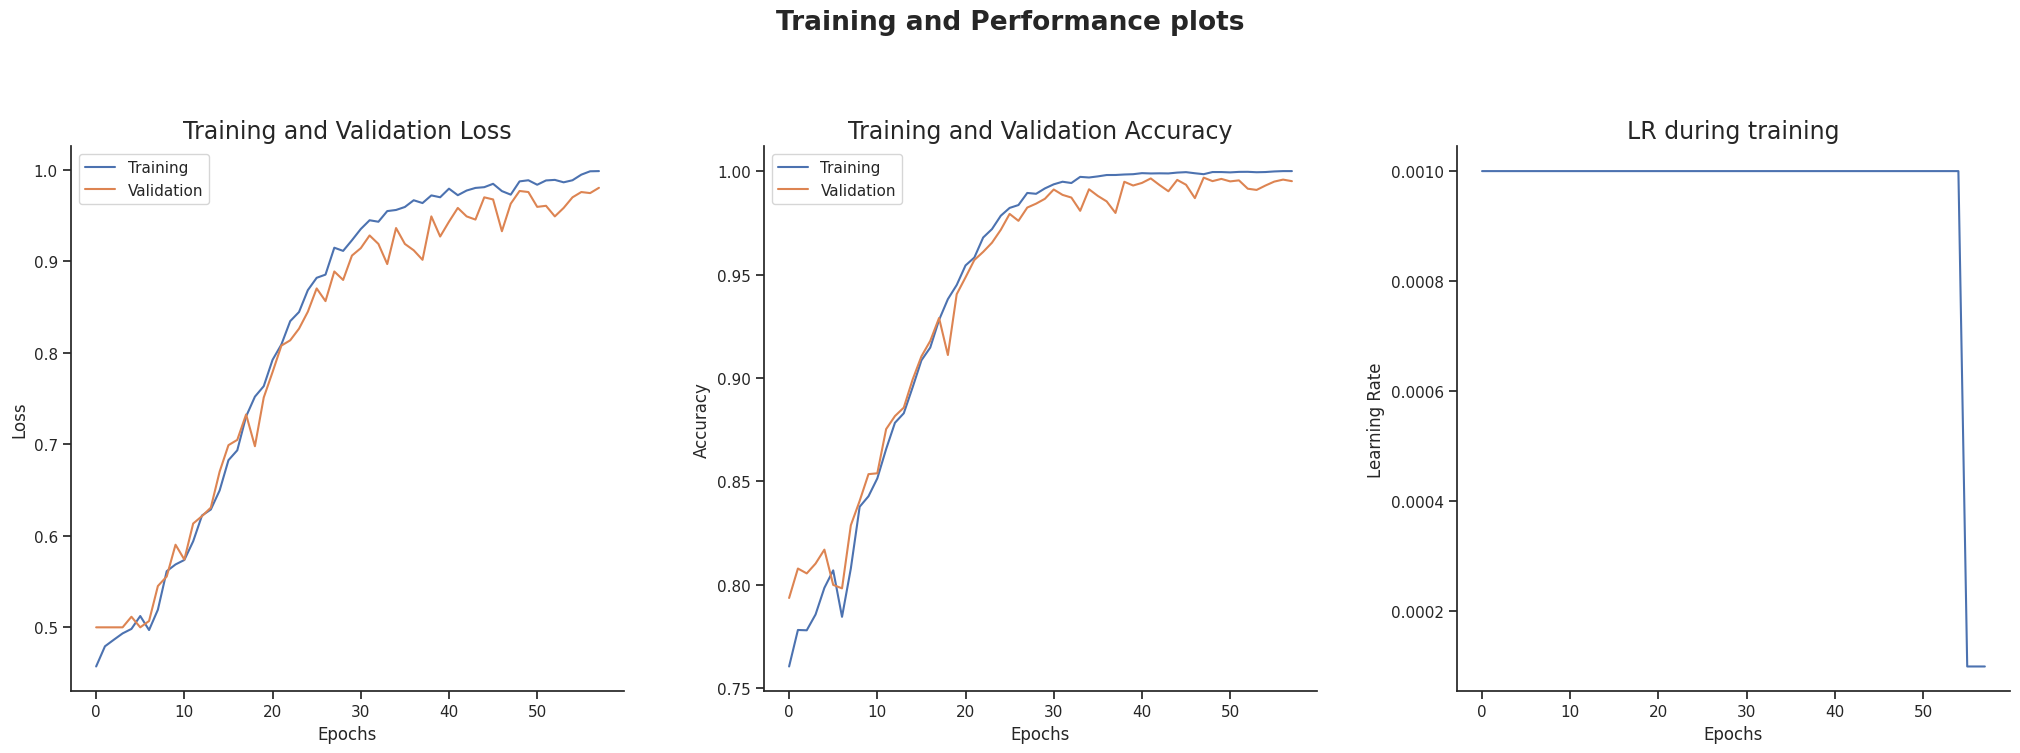

In [ ]:
fig, axarr = plt.subplots(1,3, figsize=(21, 8), sharex=True)

sns.set(style="ticks", font_scale = 1)
sns.despine(top=True, right=True, left=False, bottom=False)

ax = sns.lineplot(x = historyDF.index, y = hist.history[metricsEval[0]], ax=axarr[0], label="Training");
ax = sns.lineplot(x = historyDF.index, y = hist.history[metricsEval[5]], ax=axarr[0], label="Validation");
ax.set_ylabel('Loss')

ax = sns.lineplot(x = historyDF.index, y = hist.history[metricsEval[1]], ax=axarr[1], label="Training");
ax = sns.lineplot(x = historyDF.index, y = hist.history[metricsEval[6]], ax=axarr[1], label="Validation");
ax.set_ylabel('Accuracy')

ax = sns.lineplot(x = historyDF.index, y = hist.history[metricsEval[10]], ax=axarr[2]);
ax.set_ylabel('Learning Rate')

axarr[0].set_title('Training and Validation Loss', fontsize=17)
axarr[1].set_title('Training and Validation Accuracy', fontsize=17)
axarr[2].set_title('LR during training', fontsize=17)

for ax in axarr:
    ax.set_xlabel('Epochs')

plt.suptitle('Training and Performance plots', fontsize=19, weight='bold');
fig.tight_layout(pad=3.0)
plt.show()

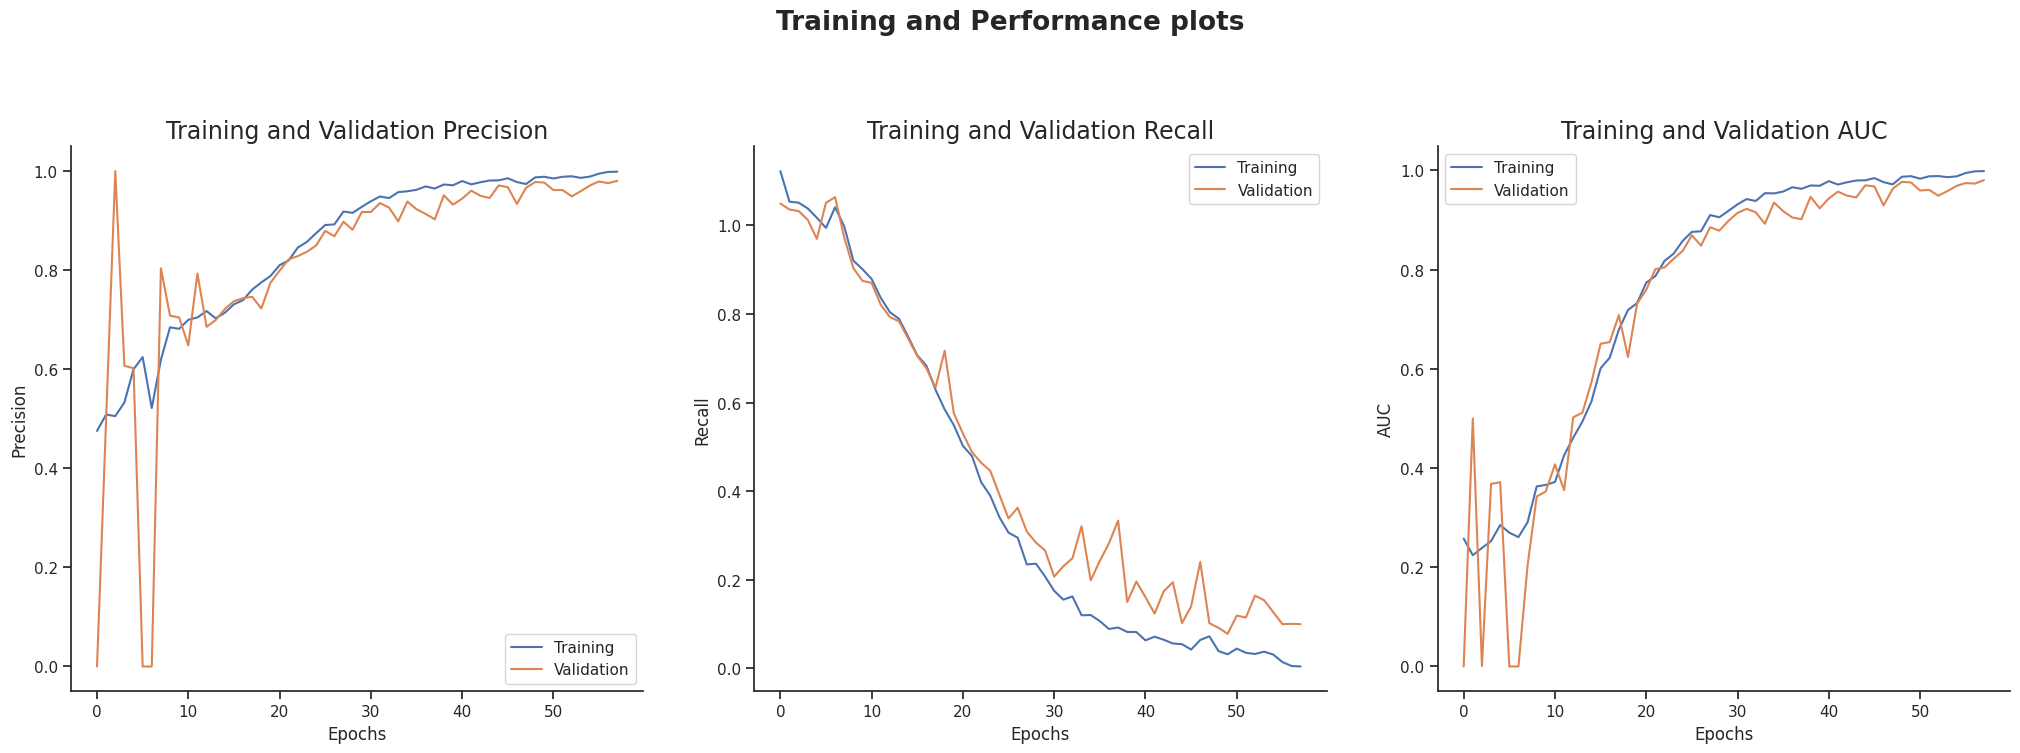

In [ ]:
fig, axarr = plt.subplots(1,3, figsize=(21, 8), sharex=True)

sns.set(style="ticks", font_scale = 1)
sns.despine(top=True, right=True, left=False, bottom=False)

ax = sns.lineplot(x = historyDF.index, y = hist.history[metricsEval[3]], ax=axarr[0], label="Training");
ax = sns.lineplot(x = historyDF.index, y = hist.history[metricsEval[8]], ax=axarr[0], label="Validation");
ax.set_ylabel('Precision')

ax = sns.lineplot(x = historyDF.index, y = hist.history[metricsEval[2]], ax=axarr[1], label="Training");
ax = sns.lineplot(x = historyDF.index, y = hist.history[metricsEval[7]], ax=axarr[1], label="Validation");
ax.set_ylabel('Recall')

ax = sns.lineplot(x = historyDF.index, y = hist.history[metricsEval[4]], ax=axarr[2], label="Training");
ax = sns.lineplot(x = historyDF.index, y = hist.history[metricsEval[9]], ax=axarr[2], label="Validation");
ax.set_ylabel('AUC')

axarr[0].set_title('Training and Validation Precision', fontsize=17)
axarr[1].set_title('Training and Validation Recall', fontsize=17)
axarr[2].set_title('Training and Validation AUC', fontsize=17)

for ax in axarr:
    ax.set_xlabel('Epochs')

plt.suptitle('Training and Performance plots', fontsize=19, weight='bold');
fig.tight_layout(pad=3.0)
plt.show()

In [ ]:
loss , acc , recall , precision , auc = model.evaluate(train_dataset)
print("\n---------------- Evaluation on Train DataSet ----------------\n")
print(f'Loss on Train set: {loss:.4f}')
print(f'Accuracy on Train set: {acc*100:.2f}%')
print(f'Recall on Train set: {recall:.2f}')
print(f'Precision on Train set: {precision:.2f}')
print(f'AUC on Train set: {auc:.2f}')

77/77 ━━━━━━━━━━━━━━━━━━━━ 87s 1s/step - accuracy: 0.9993 - auc_3: 1.0000 - loss: 0.0032 - precision_3: 0.9993 - recall_3: 0.9993

---------------- Evaluation on Train DataSet ----------------

Loss on Train set: 0.0038
Accuracy on Train set: 99.90%
Recall on Train set: 1.00
Precision on Train set: 1.00
AUC on Train set: 1.00


In [ ]:
loss , acc , recall , precision , auc = model.evaluate(val_dataset)
print("\n---------------- Evaluation on Validation DataSet ----------------\n")
print(f'Loss on Validation set: {loss:.2f}')
print(f'Accuracy on Validation set: {acc*100:.2f}%')
print(f'Recall on Validation set: {recall:.2f}')
print(f'Precision on Validation set: {precision:.2f}')
print(f'AUC on Validation set: {auc:.2f}')

14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 312ms/step - accuracy: 0.9814 - auc_3: 0.9969 - loss: 0.0863 - precision_3: 0.9814 - recall_3: 0.9814

---------------- Evaluation on Validation DataSet ----------------

Loss on Validation set: 0.10
Accuracy on Validation set: 98.03%
Recall on Validation set: 0.98
Precision on Validation set: 0.98
AUC on Validation set: 1.00


In [ ]:
loss , acc , recall , precision , auc = model.evaluate(test_dataset)
print("\n---------------- Evaluation on Test DataSet ----------------\n")
print(f'Loss on Test set: {loss:.2f}')
print(f'Accuracy on Test set: {acc*100:.2f}%')
print(f'Recall on Test set: {recall:.2f}')
print(f'Precision on Test set: {precision:.2f}')
print(f'AUC on Test set: {auc:.2f}')

10/10 ━━━━━━━━━━━━━━━━━━━━ 125s 14s/step - accuracy: 0.9860 - auc_3: 0.9982 - loss: 0.0466 - precision_3: 0.9860 - recall_3: 0.9860

---------------- Evaluation on Test DataSet ----------------

Loss on Test set: 0.08
Accuracy on Test set: 97.34%
Recall on Test set: 0.97
Precision on Test set: 0.97
AUC on Test set: 1.00


In [ ]:
y_pred = model.predict(test_dataset)
predictions = np.array(list(map(lambda x: np.argmax(x), y_pred)))
y_true = test_dataset.classes
cr_indexes = list(class2label.keys())
classes = list(class2label.values())
print(classification_report(y_true, predictions, labels = cr_indexes, target_names = classes))

10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 392ms/step
                  precision    recall  f1-score   support

    MildDemented       0.97      1.00      0.98        89
ModerateDemented       1.00      0.83      0.91         6
     NonDemented       0.96      0.99      0.98       320
VeryMildDemented       1.00      0.94      0.97       224

        accuracy                           0.97       639
       macro avg       0.98      0.94      0.96       639
    weighted avg       0.97      0.97      0.97       639



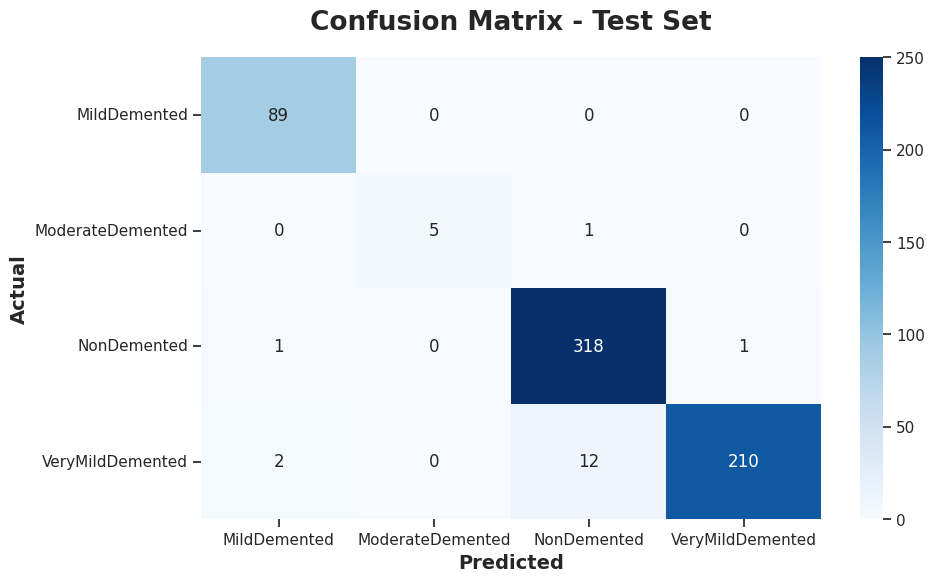

In [ ]:
CMatrix = pd.DataFrame(confusion_matrix(y_true, predictions), columns = classes, index = classes)

plt.figure(figsize=(10, 6))
ax = sns.heatmap(CMatrix, annot = True, fmt = 'g' ,vmin = 0, vmax = 250,cmap = 'Blues')
ax.set_xlabel('Predicted',fontsize = 14,weight = 'bold')
ax.set_xticklabels(ax.get_xticklabels(),rotation =0);
ax.set_ylabel('Actual',fontsize = 14,weight = 'bold')
ax.set_yticklabels(ax.get_yticklabels(),rotation =0);
ax.set_title('Confusion Matrix - Test Set', fontsize = 19, weight = 'bold', pad=20);
plt.savefig("confusion_matrix.png")

----------------- Overall Results -----------------
Accuracy Result: 97.34%
Precision Result: 98.08%
Recall Result: 94.11%


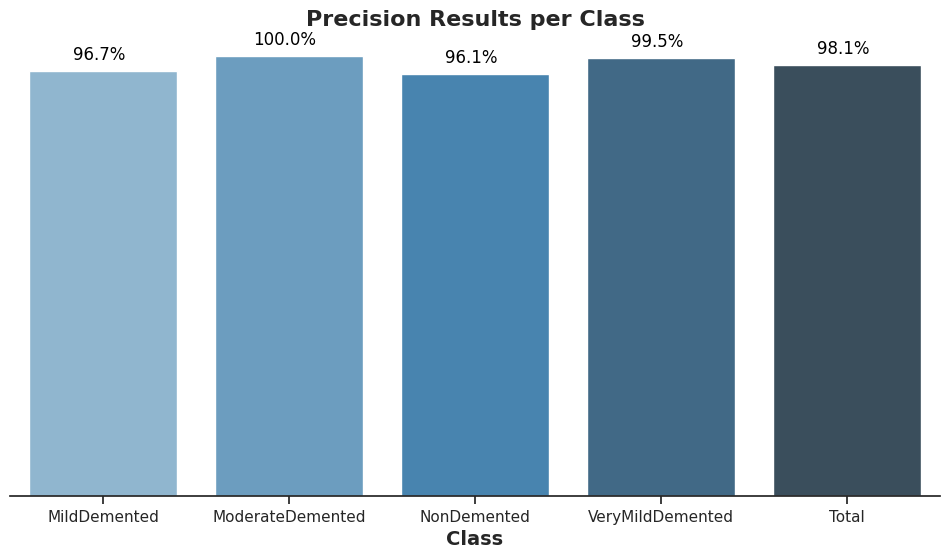

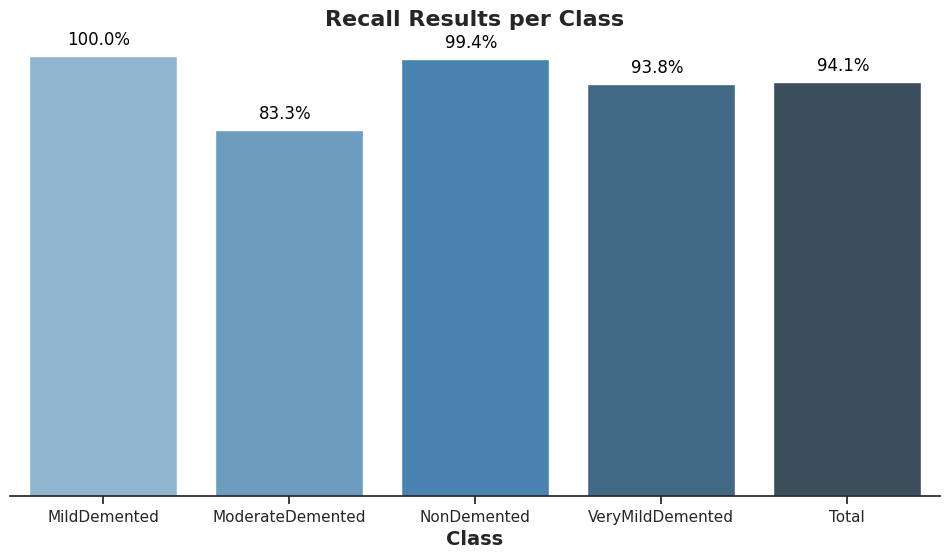

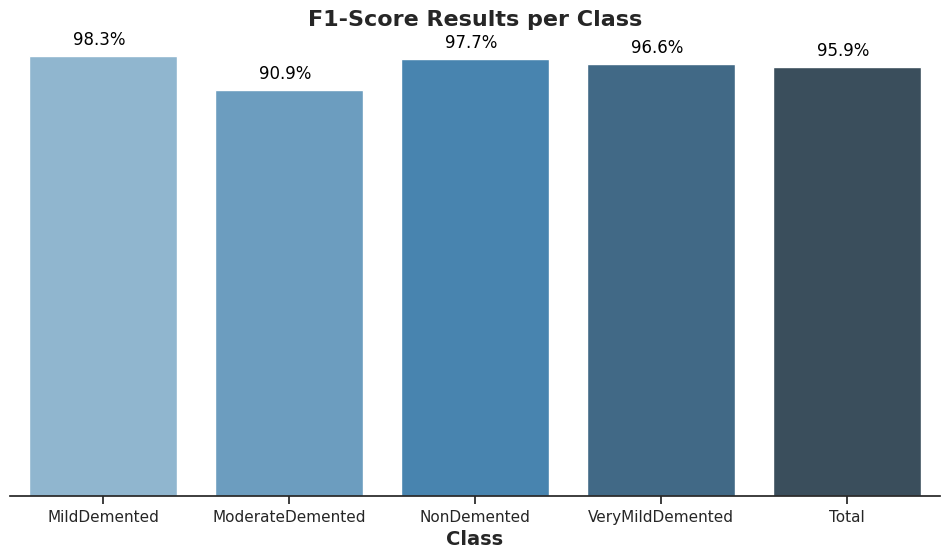

In [ ]:
acc = accuracy_score(y_true, predictions)

results_all = precision_recall_fscore_support(y_true, predictions, average='macro', zero_division=1)
results_class = precision_recall_fscore_support(y_true, predictions, average=None, zero_division=1)

metric_columns = ['Precision','Recall', 'F1-Score','S']
all_df = pd.concat([pd.DataFrame(list(results_class)).T,pd.DataFrame(list(results_all)).T])
all_df.columns = metric_columns
all_df.index = classes+['Total']

def metrics_plot(df,metric):
    plt.figure(figsize=(12,6))
    ax = sns.barplot(data=df, x=df.index, y=metric, palette = "Blues_d")
    #Bar Labels
    for p in ax.patches:
        ax.annotate("%.1f%%" % (100*p.get_height()), (p.get_x() + p.get_width() / 2., abs(p.get_height())),
        ha='center', va='bottom', color='black', xytext=(-3, 5),rotation = 'horizontal',textcoords='offset points')
    sns.despine(top=True, right=True, left=True, bottom=False)
    ax.set_xlabel('Class',fontsize = 14,weight = 'bold')
    ax.set_ylabel(metric,fontsize = 14,weight = 'bold')
    ax.set(yticklabels=[])
    ax.axes.get_yaxis().set_visible(False)
    plt.title(metric+ ' Results per Class', fontsize = 16,weight = 'bold');

metrics_plot(all_df, 'Precision')       # Results by Class
metrics_plot(all_df, 'Recall')          # Results by Class
metrics_plot(all_df, 'F1-Score')         # Results by Class
print('----------------- Overall Results -----------------')
print('Accuracy Result: %.2f%%'%(acc*100))                   # Accuracy of the whole Dataset
print('Precision Result: %.2f%%'%(all_df.iloc[4,0]*100))     # Precision of the whole Dataset
print('Recall Result: %.2f%%'%(all_df.iloc[4,1]*100))        # Recall of the whole Dataset